In [16]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import ZeroPadding2D
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
import os
import numpy as np
import matplotlib.pyplot as plt
 
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64 
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
    # C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model
 
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model
 
# load and prepare training images
#def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y 
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, dataset)
 
 
 
photo_path = os.environ.get("DATASET_PHOTO_PATH")
#Get the list of files in the path and sort it
photo_list = os.listdir(photo_path)
photo_list.sort()
photo_array= np.asarray([np.asarray(plt.imread(photo_path+image)) for image in photo_list])

sketch_path = os.environ.get("DATASET_SKETCH_PATH")
#Get the list of files in the path and sort it
sketch_list = os.listdir(sketch_path)
sketch_list.sort()
sketch_array= np.asarray([np.asarray(plt.imread(sketch_path+sketch)) for sketch in sketch_list])

dataset = photo_array[100:200], sketch_array[100:200]
dataset = (photo_array[100:200] - 127.5) / 127.5 , (sketch_array[100:200] - 127.5) / 127.5


print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)


Loaded (100, 256, 256, 3) (100, 256, 256, 3)


In [17]:
# train model
train(d_model, g_model, gan_model, dataset)

1/1 [==============================] - 4s 4s/step
>1, d1[0.479] d2[0.786] g[85.336]
1/1 [==============================] - 0s 218ms/step
>2, d1[0.771] d2[0.499] g[87.371]
1/1 [==============================] - 0s 106ms/step
>3, d1[0.478] d2[0.503] g[80.172]
1/1 [==============================] - 0s 118ms/step
>4, d1[0.378] d2[0.522] g[68.641]
1/1 [==============================] - 0s 105ms/step
>5, d1[0.439] d2[0.532] g[61.829]
1/1 [==============================] - 0s 102ms/step
>6, d1[0.530] d2[0.525] g[68.316]
1/1 [==============================] - 0s 96ms/step
>7, d1[0.411] d2[0.428] g[70.268]
1/1 [==============================] - 0s 103ms/step
>8, d1[0.653] d2[0.498] g[69.670]
1/1 [==============================] - 0s 100ms/step
>9, d1[0.403] d2[0.417] g[54.373]
1/1 [==============================] - 0s 101ms/step
>10, d1[0.538] d2[0.357] g[51.652]
1/1 [==============================] - 0s 93ms/step
>11, d1[0.358] d2[0.434] g[65.942]
1/1 [==============================] - 0s 106m

In [26]:
#A REFAIRE

def pred(X_pred: pd.DataFrame = None) -> np.ndarray:
    """
    Make a prediction using the latest trained model
    """

    from FF2S.ml_logic.registry import load_model

    model = load_model()

    X_processed = (X_pred - 127.5)/127.5
    X_processed = X_processed.reshape((1, 256, 256, 3))
    X_processed = X_processed[0]

    y_pred = model.predict(X_processed)

    print("\n✅ prediction done: ", y_pred, y_pred.shape)

    return y_pred

NameError: name 'pd' is not defined

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


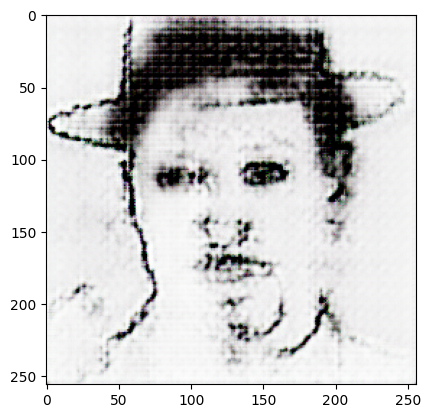

In [30]:
from keras.models import load_model
from keras.utils import load_img

model = load_model('model_000600.h5')
#image_test = load_img(photo_path+"image0143.jpg")

image_test = (photo_array[5] -127.5)/ 127.5
image_test = image_test.reshape((1, 256, 256, 3))
plt.imshow(model.predict(image_test)[0])

array([[[ 75,  50,  10],
        [ 76,  53,  12],
        [ 73,  53,  16],
        ...,
        [192, 182, 172],
        [196, 184, 172],
        [197, 185, 171]],

       [[ 82,  57,  16],
        [ 81,  58,  17],
        [ 77,  58,  18],
        ...,
        [193, 183, 173],
        [196, 184, 172],
        [197, 185, 171]],

       [[ 88,  65,  21],
        [ 85,  64,  19],
        [ 81,  62,  19],
        ...,
        [196, 186, 176],
        [199, 187, 175],
        [200, 188, 176]],

       ...,

       [[ 21,  18,   0],
        [ 23,  20,   1],
        [ 26,  23,   4],
        ...,
        [128, 114,  79],
        [108,  93,  60],
        [ 92,  77,  46]],

       [[ 22,  19,   0],
        [ 24,  21,   2],
        [ 27,  24,   5],
        ...,
        [138, 124,  89],
        [119, 106,  72],
        [ 95,  82,  48]],

       [[ 25,  22,   3],
        [ 26,  23,   4],
        [ 30,  27,   8],
        ...,
        [146, 132,  97],
        [127, 114,  80],
        [ 96,  83,  49]]

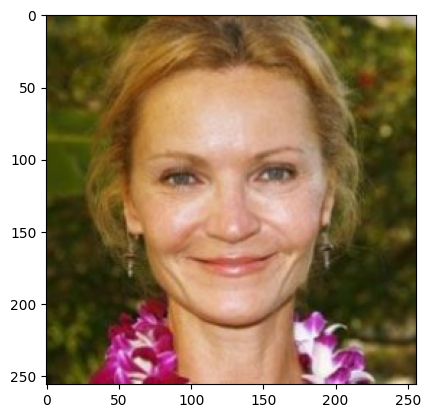

In [6]:
plt.imshow(photo_array[142])
photo_array[142]

In [4]:
photo_array

NameError: name 'photo_array' is not defined

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

photo_path = os.path.join(os.getcwd(),"..", "..", "..", "data", "preproc_photo/")
#"../data/preproc_photo/"
#Get the list of files in the path and sort it
photo_list = os.listdir(photo_path)
photo_list.sort()
photo_array= np.asarray([np.asarray(plt.imread(photo_path+image)) for image in photo_list])
photo_array.shape

(2006, 256, 256, 3)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

sketch_path = os.path.join(os.getcwd(),"..", "..", "..", "data", "preproc_sketch/")
#Get the list of files in the path and sort it
sketch_list = os.listdir(sketch_path)
sketch_list.sort()
sketch_array= np.asarray([np.asarray(plt.imread(sketch_path+sketch)) for sketch in sketch_list])
sketch_array

array([[[[240, 240, 240],
         [242, 242, 242],
         [244, 244, 244],
         ...,
         [240, 240, 240],
         [244, 244, 244],
         [245, 245, 245]],

        [[247, 247, 247],
         [248, 248, 248],
         [249, 249, 249],
         ...,
         [222, 222, 222],
         [229, 229, 229],
         [238, 238, 238]],

        [[248, 248, 248],
         [249, 249, 249],
         [248, 248, 248],
         ...,
         [229, 229, 229],
         [230, 230, 230],
         [236, 236, 236]],

        ...,

        [[251, 251, 251],
         [252, 252, 252],
         [250, 250, 250],
         ...,
         [248, 248, 248],
         [249, 249, 249],
         [250, 250, 250]],

        [[249, 249, 249],
         [250, 250, 250],
         [249, 249, 249],
         ...,
         [247, 247, 247],
         [248, 248, 248],
         [249, 249, 249]],

        [[254, 254, 254],
         [251, 251, 251],
         [249, 249, 249],
         ...,
         [247, 247, 247],
        

In [20]:
dataset = photo_array[0:100], sketch_array[0:100]
dataset

array([[[[ 50, 151, 117],
         [ 47, 148, 114],
         [ 46, 147, 113],
         ...,
         [ 73, 170, 116],
         [ 75, 169, 116],
         [ 76, 170, 117]],

        [[ 55, 156, 122],
         [ 53, 154, 120],
         [ 51, 152, 118],
         ...,
         [ 78, 175, 121],
         [ 79, 173, 120],
         [ 79, 173, 120]],

        [[ 56, 157, 123],
         [ 55, 156, 122],
         [ 54, 155, 121],
         ...,
         [ 84, 181, 127],
         [ 83, 177, 124],
         [ 82, 176, 123]],

        ...,

        [[101,  66,  47],
         [ 84,  49,  30],
         [105,  70,  51],
         ...,
         [ 80,  57,  39],
         [ 71,  54,  38],
         [ 68,  52,  37]],

        [[ 99,  62,  46],
         [101,  64,  46],
         [100,  63,  45],
         ...,
         [ 75,  56,  39],
         [ 65,  52,  36],
         [ 63,  51,  37]],

        [[ 96,  59,  43],
         [104,  67,  51],
         [ 88,  51,  33],
         ...,
         [ 72,  55,  37],
        

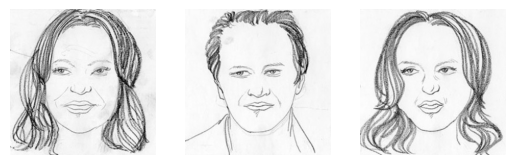

In [30]:
import matplotlib.pyplot as plt
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(sketch_array[i].astype('uint8'))

In [9]:
from keras.models import load_model
from keras.utils import load_img
import numpy as np
import matplotlib.pyplot as plt

kat = np.asarray(plt.imread("/Users/alicepannequin/Downloads/Portraits_LeWagon_221102_by_BenoitBillard-75_WEB.jpg"), dtype = "uint8")


model = load_model('/Users/alicepannequin/code/dcorballorenzo/FF2S/training_outputs/models/model_20221205-174911.h5')
#image_test = load_img(photo_path+"image0143.jpg")

image_test = (kat -127.5)/ 127.5
image_test = image_test.reshape((1, 256, 256, 3))
plt.imshow(model.predict(image_test)[0])



/Users/alicepannequin/.pyenv/versions/3.10.6/envs/FF2S/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


ValueError: cannot reshape array of size 2332800 into shape (1,256,256,3)

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


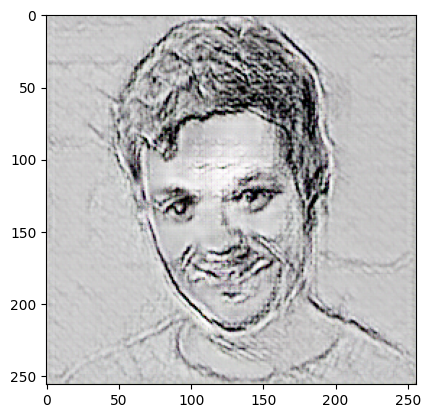

In [43]:
import cv2

model = load_model('/Users/alicepannequin/code/dcorballorenzo/FF2S/training_outputs/models/model_20221206-132553.h5')

kat = np.asarray(plt.imread("/Users/alicepannequin/Downloads/Capture d’écran 2022-12-06 à 14.48.17.jpeg"), dtype = "uint8")
kat_shape = kat.shape
kat = cv2.resize(kat, [256, 256])
kat = kat.reshape((1, 256, 256, 3))
kat = (kat-127.5)/ 127.5
plt.imshow(model.predict(kat)[0])
kat = cv2.resize(kat[1:], list(kat_shape[:2]))
plt.imshow(kat)

In [33]:
list(kat_shape[:2])

[720, 1080]

In [ ]:
from FF2S_prod.data import load_images
